# Uncertainty Quantification using Ensemble Methods for Deep Learning 

Ensemble Methods are important techniques can be adapted and used to provide Uncertainty Quantification through Prediction intervals. 

This approach follows the methodology described in Zhu (2005) and Parker (2013).

### Pros:
-Robust Uncertainty Estimates:

-Model Agnostic

-Resilience to Overfitting

-Capacity to capture Aleatoric and Epistemic Uncertainty

### Cons:
-Implementation Difficulty

-Computational Cost

# Mathematical Approach Behind Ensemble Method for Uncertainty Quantification

The provided code implements an ensemble method to quantify uncertainty in predictions. The main steps of the method are as follows:

1. **Bootstrap Sampling**: For each model, generate a bootstrap sample from the training data.
2. **Model Training**: Train each model on its respective bootstrap sample.
3. **Prediction Aggregation**: Collect predictions from each model on the test data.
4. **Uncertainty Quantification**: Compute prediction intervals using quantiles from the aggregated predictions.

Let's denote:
- $ X_{\text{train}}, y_{\text{train}} $ as the training data,
- $ X_{\text{val}}, y_{\text{val}} $ as the validation data,
- $ X_{\text{test}} $ as the test data,
- $ M $ as the number of models in the ensemble.

## Bootstrap Sampling

For each model $ i $ ( $ i = 1, 2, \ldots, M $ ), we create a bootstrap sample $ (X_{\text{resampled}}^{(i)}, y_{\text{resampled}}^{(i)}) $ by sampling with replacement from $ (X_{\text{train}}, y_{\text{train}}) $.

## Model Training

Each model $ i $ is trained on its respective bootstrap sample:
$ \text{Model}_i \leftarrow \text{Train} \left( X_{\text{resampled}}^{(i)}, y_{\text{resampled}}^{(i)} \right) $

## Prediction Aggregation

After training, each model makes predictions on the test data $ X_{\text{test}} $. Let $ \hat{y}^{(i)} $ denote the predictions of model $ i $:
$ \hat{y}^{(i)} = \text{Model}_i(X_{\text{test}}) $
Collect all predictions in a matrix:
$ \hat{Y} = \begin{bmatrix}
\hat{y}^{(1)} & \hat{y}^{(2)} & \cdots & \hat{y}^{(M)}
\end{bmatrix} $

## Uncertainty Quantification

To quantify uncertainty, we compute the prediction interval for each test sample using the quantiles of the aggregated predictions. For a given significance level $ \alpha $, the lower bound $ y_{\text{lb}} $ and upper bound $ y_{\text{ub}} $ of the prediction interval are computed as:
$ y_{\text{lb}} = Q_{\frac{\alpha}{2}}(\hat{Y}) $
$ y_{\text{ub}} = Q_{1 - \frac{\alpha}{2}}(\hat{Y}) $
where $ Q_p(\hat{Y}) $ denotes the $ p $-th quantile of the predictions.

The final prediction for each test sample is the median of the aggregated predictions:
$ \hat{y} = Q_{0.5}(\hat{Y}) $


### Step 1: Write import statements

In [4]:
import sys
sys.path.append("../../")

In [5]:
import numpy as np
from sklearn.utils import resample
from scipy.stats import gaussian_kde
from scipy import stats
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from common_uq import plot_uq_quality

### Step 2: Load and pre-process DataSet

This dataset contains `1500` instances, mix of continuous and discrete.

Age: Customer's age

Gender: Customer's gender (0: Male, 1: Female)

Annual Income: Annual income of the customer in dollars

Number of Purchases: Total number of purchases made by the customer

Product Category: Category of the purchased product (0: Electronics, 1: Clothing, 2: Home Goods, 3: Beauty, 4: Sports)

Time Spent on Website: Time spent by the customer on the website in minutes

Loyalty Program: Whether the customer is a member of the loyalty program (0: No, 1: Yes)

Discounts Availed: Number of discounts availed by the customer (range: 0-5)

PurchaseStatus (Target Variable): Likelihood of the customer making a purchase (0: No, 1: Yes)

In [6]:
df=pd.read_csv("customer_purchase_data.csv")
X = df[['Age', 'Gender','AnnualIncome','NumberOfPurchases','ProductCategory','TimeSpentOnWebsite','LoyaltyProgram','DiscountsAvailed']]
y = df['PurchaseStatus']
df.head()

,Age,Gender,AnnualIncome,NumberOfPurchases,ProductCategory,TimeSpentOnWebsite,LoyaltyProgram,DiscountsAvailed,PurchaseStatus
0,40,1,66120.267939,8,0,30.568601,0,5,1
1,20,1,23579.773583,4,2,38.240097,0,5,0
2,27,1,127821.306432,11,2,31.633212,1,0,1
3,24,1,137798.623120,19,3,46.167059,0,4,1
4,31,1,99300.964220,19,1,19.823592,0,0,1


In [7]:
X_nottest,X_test,y_nottest,y_test= train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_train,X_val,y_train,y_val= train_test_split(X_nottest, y_nottest, test_size=0.3, random_state=42, shuffle=True)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Step 3: Create NN Model

In [8]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy()]
)

### Step 4: Train NN using Bootstrap sampling

In [9]:
num_models = 100
models = []
predictions = []
alpha=0.05

for i in range(num_models):
    X_resampled, y_resampled = resample(X_train, y_train)
    
    model.fit(X_resampled, y_resampled, epochs=5, batch_size=40, validation_data=(X_val, y_val))
    preds=[i[0] for i in model.predict(X_test)]
    predictions.append(preds)

Epoch 1/5
19/19 [==============================] - 1s 13ms/step - loss: 0.7018 - binary_accuracy: 0.6082 - val_loss: 13146.7402 - val_binary_accuracy: 0.5175
Epoch 2/5
19/19 [==============================] - 0s 3ms/step - loss: 0.6582 - binary_accuracy: 0.6190 - val_loss: 12018.0742 - val_binary_accuracy: 0.5175
Epoch 3/5
19/19 [==============================] - 0s 3ms/step - loss: 0.6238 - binary_accuracy: 0.6272 - val_loss: 10787.4473 - val_binary_accuracy: 0.5175
Epoch 4/5
19/19 [==============================] - 0s 2ms/step - loss: 0.5927 - binary_accuracy: 0.6395 - val_loss: 9762.3926 - val_binary_accuracy: 0.5175
Epoch 5/5
15/15 [==============================] - 0s 716us/step
Epoch 1/5
19/19 [==============================] - 0s 4ms/step - loss: 0.5512 - binary_accuracy: 0.7048 - val_loss: 7363.6260 - val_binary_accuracy: 0.5175
Epoch 2/5
19/19 [==============================] - 0s 2ms/step - loss: 0.5279 - binary_accuracy: 0.7293 - val_loss: 5965.5586 - val_binary_accuracy: 0.

### Step 5: Predicting Uncertainty

In [10]:
y_pred=model.predict(X_test)
y_pred=[i[0] for i in y_pred]
y_lb = np.quantile(predictions, q=0.5 * alpha, axis=0)
y_ub=np.quantile(predictions,q=(1. - 0.5 * alpha), axis=0)
y_pred=np.quantile(predictions,q=0.5,axis=0)

15/15 [==============================] - 0s 1ms/step


In [17]:
data={
    'NN Score':y_pred,
    'Prediction Interval': [f"[{round(lb, 5)}, {round(ub, 5)}]" for lb, ub in zip(y_lb, y_ub)],
    'Delta':y_ub-y_lb,
    'Target Class':y_test
}
df=pd.DataFrame(data)
df1= df.sort_values(by='NN Score', ascending=False)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
print(df)
sorted_y_test_1 = df1['Target Class'].values

      NN Score Prediction Interval    Delta  Target Class
1116  0.982859  [0.74441, 0.99066] 0.246251             1
1368  0.005649   [0.00186, 0.0819] 0.080040             0
422   0.110777  [0.04556, 0.26147] 0.215915             0
413   0.007371  [0.00372, 0.02723] 0.023512             0
451   0.992259  [0.80355, 0.99766] 0.194116             1
861   0.002723  [0.00073, 0.00752] 0.006790             0
1063  0.972877  [0.80935, 0.99057] 0.181225             1
741   0.046620  [0.01233, 0.12039] 0.108060             0
1272  0.020498  [0.01474, 0.09496] 0.080220             0
259   0.010437  [0.00585, 0.07081] 0.064957             0
888   0.999716   [0.9539, 0.99992] 0.046022             1
1432  0.688754  [0.51081, 0.82272] 0.311917             1
712   0.053475  [0.03388, 0.13981] 0.105925             0
1382  0.275464   [0.1755, 0.39014] 0.214643             0
70    0.907835  [0.62481, 0.95033] 0.325518             1
1268  0.053121  [0.01941, 0.22888] 0.209475             0
1491  0.981074

### Step 6: How to use the prediction interval in our favour?

In [18]:
score=np.quantile(predictions, q=0.75, axis=0)
data={
    'NN Score':y_pred,
    'Prediction Interval': [f"[{round(lb, 5)}, {round(ub, 5)}]" for lb, ub in zip(y_lb, y_ub)],
    'Delta':y_ub-y_lb,
    'New Score': y_pred*(1-y_ub+y_lb),
    'Target Class':y_test
}
df=pd.DataFrame(data)
df= df.sort_values(by='New Score', ascending=False)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
print(df)
sorted_y_test_2 = df['Target Class'].values

      NN Score Prediction Interval    Delta  New Score  Target Class
275   0.999805  [0.95576, 0.99994] 0.044185   0.955628             1
888   0.999716   [0.9539, 0.99992] 0.046022   0.953707             1
1249  0.999969      [0.94544, 1.0] 0.054554   0.945417             1
534   0.999997      [0.94531, 1.0] 0.054688   0.945310             1
736   0.999979      [0.93623, 1.0] 0.063771   0.936209             1
858   0.999977       [0.9276, 1.0] 0.072396   0.927583             1
1125  0.999091  [0.92724, 0.99962] 0.072382   0.926775             1
49    0.999815  [0.90842, 0.99998] 0.091560   0.908272             1
1374  0.993553  [0.90789, 0.99695] 0.089061   0.905066             1
1391  0.997325  [0.90166, 0.99884] 0.097179   0.900406             1
1083  0.999795  [0.89308, 0.99996] 0.106884   0.892932             1
571   0.990313  [0.89577, 0.99624] 0.100468   0.890819             1
1169  0.969818  [0.89595, 0.98503] 0.089077   0.883429             1
59    0.999755   [0.8821, 0.99996]

## The importance of Uncertainty in ML models

### Instance 1

Predicted Score: 0.817

Interval of Prediction: $[0.636,0.888]$

Delta: 0.252

### Instance 2

Predicted Score: 0.827

Interval of Prediction: $[0.774,0.870]$

Delta: 0.095

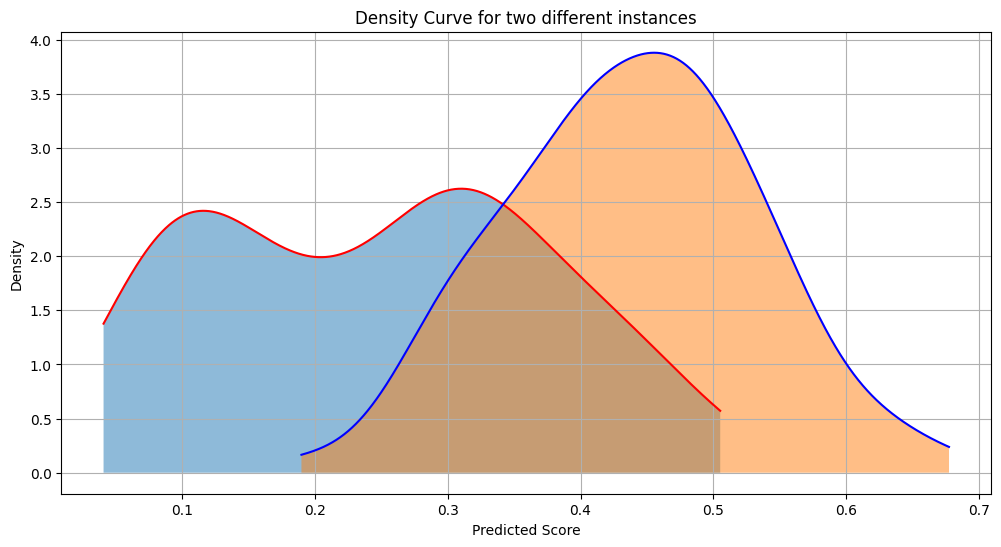

In [14]:
predictions=np.array(predictions)
transposed_array = predictions.T
x=transposed_array[189]
w=transposed_array[236]

density = gaussian_kde(x)
x_vals = np.linspace(min(x), max(x), 1000)
density_vals = density(x_vals)

density = gaussian_kde(w)
w_vals=np.linspace(min(w), max(w), 1000)
density_vals_w = density(w_vals)

plt.figure(figsize=(12, 6))
plt.plot(x_vals, density_vals, color='red')
plt.fill_between(x_vals, density_vals, alpha=0.5)

plt.plot(w_vals, density_vals_w, color='blue')
plt.fill_between(w_vals, density_vals_w, alpha=0.5)

plt.title("Density Curve for two different instances")
plt.xlabel("Predicted Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()

### Step 7: Assess UQ Quality

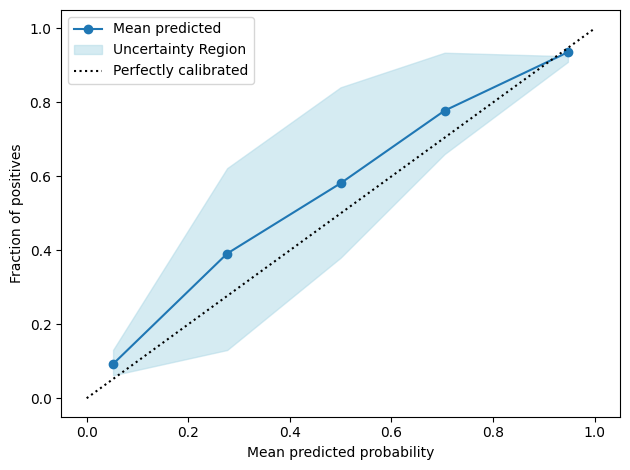

In [16]:
plot_uq_quality(y_test,y_pred,y_ub,y_lb,bins_num=5)

## References

1. Parker, Wendy S. "Ensemble modeling, uncertainty and robust predictions." Wiley interdisciplinary reviews: Climate change 4.3 (2013): 213-223.
2. Zhu, Yuejian. "Ensemble forecast: A new approach to uncertainty and predictability." Advances in atmospheric sciences 22 (2005): 781-788.